# MODEL CODE - UNIDIRECTIONAL RNN WITH LSTM CELLS

### Importing packages 

In [10]:
import numpy as np
from collections import OrderedDict
from itertools import chain
from rdkit import Chem
from sklearn.utils import shuffle
import tensorflow as tf
import pandas as pd
import re



In [11]:
#data = np.genfromtxt('ChEMBL.csv',dtype='U') #inladen ChEMBL33.csv
#len(data)

67

### Visualising random structures in ChEMBL.

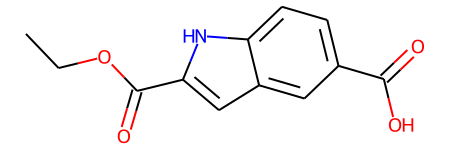

In [4]:
Chem.MolFromSmiles(data[6])

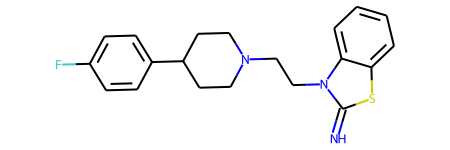

In [5]:
Chem.MolFromSmiles(data[20])

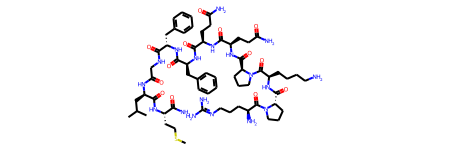

In [6]:
Chem.MolFromSmiles(data[50])

### Removing unwanted data

In [7]:
def remove_unwanted_data(filename_in='', filename_out='',  invalid=True, duplicates=True, salts=True, stereochem=True, canonicalize=True):
    """Pre-processing of SMILES based on the user-defined parameters
            :param filename_in     path to the file containing the SMILES to pretreat (SMILES only) -- default = ChEMBL
            :param filename_out    path for file export -- default = ../data/
            :param invalid         if True (default), removes invalid SMILES
            :param duplicates      if True (default), removes duplicates
            :param salts           if True (default), removes salts
            :param stereochem      if True (default), removes stereochemistry
            :param canonicalize    if True (default), produces canonical SMILES
    """

    from preprocessor import Preprocessor
    p = Preprocessor(filename_in)

    print(Fore.GREEN + 'Pre-processing of "' + filename_in + '" started.')


    # user-defined pretreatment
    if invalid:
        p.remove_not_valid()
        print(Fore.GREEN + ' invalid SMILES - removed.')
        print(Style.RESET_ALL)

    if duplicates:
        p.remove_duplicates()
        print(Fore.GREEN + ' duplicate SMILES - removed.')
        print(Style.RESET_ALL)

    if salts:
        p.remove_salts()
        print(Fore.GREEN + ' salts - removed.')
        print(Style.RESET_ALL)

    if stereochem:
        p.remove_stereochem()
        print(Fore.GREEN + ' stereochemistry - removed.')
        print(Style.RESET_ALL)

    if canonicalize:
        p.canonicalize()
        print(Fore.GREEN + ' canonicalized SMILES.')
        print(Style.RESET_ALL)

    #save data to file
    p.save_data(filename_out)

    data = p.get_data()
    print(data[:5])


remove_unwanted_data(filename_in='ChEMBL33', filename_out='preprocessed_data.csv')
data_no_descriptors=pd.read_csv('preprocessed_example_data.csv')

ModuleNotFoundError: No module named 'preprocessor'

### Visualisation of preprocessed data

In [ ]:
Chem.MolFromSmiles(data[6])

In [ ]:
Chem.MolFromSmiles(data[6])

In [ ]:
Chem.MolFromSmiles(data[6])

### Creating dictionary from preprocessed data

In this part a dictionary is made that maps each unique character to an unique integer. 

In [39]:
#function to make dictionary taking into account Br and Cl.
def create_dictionary(smiles_dataset):
    unique_char = set()

    pattern = re.compile(r"[A-Z][a-z]?|\d+|[()[\]=]|Br|Cl")

    for smiles in smiles_dataset:
        matches = pattern.findall(smiles)
        unique_char.update(matches)

    char_list = list(unique_char)
    char_to_int = {char: index for index, char in enumerate(char_list)}
    int_to_char = {index: char for index, char in enumerate(char_list)}
    
    char_to_int.update({"E" : len(char_to_int)})
    char_to_int.update({"G" : len(char_to_int)})
    
    int_to_char.update({len(int_to_char) : "E"})
    int_to_char.update({len(int_to_char) : "G"})
    
    return char_to_int, int_to_char #tuple of dict. tuple[0]=char_to_int and tuple[1]=int_to_char

dictionaries = create_dictionary(data_no_descriptors)
print(dictionaries)

({'5': 0, '4': 1, '=': 2, '12': 3, '3': 4, 'F': 5, '23': 6, '1': 7, 'Nc': 8, '7': 9, 'N': 10, '34': 11, ')': 12, '43': 13, 'I': 14, 'Cc': 15, 'Cn': 16, 'Sc': 17, '(': 18, '32': 19, 'H': 20, 'Cl': 21, '21': 22, '8': 23, '13': 24, '6': 25, '2': 26, 'C': 27, ']': 28, 'O': 29, 'Br': 30, 'S': 31, 'Oc': 32, '[': 33, 'E': 34, 'G': 35}, {0: '5', 1: '4', 2: '=', 3: '12', 4: '3', 5: 'F', 6: '23', 7: '1', 8: 'Nc', 9: '7', 10: 'N', 11: '34', 12: ')', 13: '43', 14: 'I', 15: 'Cc', 16: 'Cn', 17: 'Sc', 18: '(', 19: '32', 20: 'H', 21: 'Cl', 22: '21', 23: '8', 24: '13', 25: '6', 26: '2', 27: 'C', 28: ']', 29: 'O', 30: 'Br', 31: 'S', 32: 'Oc', 33: '[', 34: 'E', 35: 'G'})


### Creating subsets from preprocessed data

Method is from Skinnider paper, but adapted.

In [ ]:
def subset_splitting(datafile, num_subsets=6, step_size=25000): 
    sample_sizes = [50000 + (i * step_size) for i in range(num_subsets)]
    #remove all subset sizes > than datafile size, as we cannot generate these
    sample_sizes = [size for size in sample_sizes if size < len(datafile)]
    return sample_sizes

sample_sizes= subset_splitting(data_no_descriptors, num_subsets=6, step_size=25000)

In [44]:
def subset_creation(datafile, sample_sizes):
    df = pd.read_csv(datafile)
    subsets = {}  # Dictionary to store subsets with group size as key
    for groupsize in sample_sizes:
        subgroup = df.sample(groupsize, replace=True, random_state=42)
        subsets[groupsize] = subgroup
    return subsets

subset_dict=subset_creation('preprocessed_data.csv',sample_sizes)

ValueError: Invalid file path or buffer object type: <class 'numpy.ndarray'>

### Lipinski descriptor distributions for created subset

In [ ]:
# Function to calculate Lipinski descriptors
def lipinski_descriptors(smiles):
    """Calculates the descriptors that are within the Lipinski rule of 5 and returns them as a dictionary"""
    mol = Chem.MolFromSmiles(smiles)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    return {'Hydrogen Bond Donors': hbd, 'Hydrogen Bond Acceptors': hba, 'Molecular Weight': mw, 'LogP': logp}

def visualisation_distributions(data, output_filename):
    descriptor_list = [] #by creating list of dictionaries, we can easily set up dataframe in panda. 
    for smiles in data['canonical_smiles']:
        descriptor_list.append(lipinski_descriptors(smiles))
    data_with_descriptors = pd.concat([data, pd.DataFrame(descriptor_list)], axis=1)
    
    descriptor_columns = list(data_with_descriptors.columns)[1:]
    plt.figure(figsize=(15, 8))
    plt.suptitle('Density Distributions of Lipinski Descriptors', fontsize=16, fontweight='bold')
    for i, descriptor in enumerate(descriptor_columns, 1):
        plt.subplot(2, 2, i)
        sns.kdeplot(data_with_descriptors[descriptor], fill=True, color=f'C{i}', lw=2)
        plt.xlabel(descriptor)
        plt.ylabel('Density')
    
    data_with_descriptors.to_csv(output_filename, index=False)

output_filename = 'example_smiles_descr.csv'
visualisation_distributions(random_subset, output_filename)

### One-hot encoding

The encoder makes a 3D Numpy array which contains 2D one-hot encoded representations of the SMILES. This representation encodes each character in one-hot representation and adds 'endchar' symbol. It then returns two arrays; one for input sequence and the other for corresponding output.

The decoder is used to convert a 3D numpy array of 2D one-hot encoded sequences, to a list of SMILES.

In [ ]:
def encoder(data, char_to_int, max_seq):
    """
    Encodes SMILES sequences into one-hot encoding.

    Parameters:
        data (numpy.ndarray): Array containing SMILES sequences.
        char_to_int (dict): Mapping from characters to integer indices.
        max_seq (int): Length of the longest sequence in the dataset for padding.

    Returns:
        tuple: Tuple containing input and output one-hot encoded arrays.
    """
    #3D array to store one-hot encoded sequences
    one_hot =  np.zeros((data.shape[0], embed+2, len(char_to_int)),dtype=np.int8) #embedded+2 to account for begin and end characters
    
    #loop through each SMILES sequence in data set and convert.
    for i,smile in enumerate(data):
        one_hot[i,0,char_to_int["G"]] = 1
        for j,c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        one_hot[i,len(smile)+1,char_to_int["E"]] = 1
        
    #return input+output arrays
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

def decoder(array_data, int_to_char):
    """
    Decodes one-hot encoded sequences into SMILES strings.

    Parameters:
        array_data (numpy.ndarray): 3D array with 2D one-hot encoded array to be decoded.
        int_to_char (dict): Mapping from integer indices to characters.

    Returns:
        list: list of decoded SMILES strings.
    """
    gen_mol = []
    
    #iterates through each sequence in one-hot encoded array
    for i in range(array_data.shape[0]):
        decoded_seq = ""
        for j in range(array_data.shape[1]):
            char_index = np.argmax(array_data[i, j, :])
            decoded_char = int_to_char[char_index]
            
            #append char to decoded_seq untill it is end char.
            if decoded_char != "E":
                decoded_seq += decoded_char
            else:
                break
    
    #append the fully decoded sequence to the list
    gen_mol.append(decoded_seq)
    
    return gen_mol

In [ ]:
#set parameters
embed = max([len(seq) for seq in train_data])

#X: contains all characters except last of sequences & Y: contains all characters except first of sequences
X, Y = encoder(train_data, char_to_int, embed) 
X, Y = shuffle(X, Y) #shuffled for randomization

### RNN model with LSTM cells

Model is built with two LSTM layers with dropout for sequence processing. Batch normalization is applied to input and intermediate layers to enhance training stability. We also use a softmax activation function in the output layer. The model structure is mimicked to be like that of the MORET PAPER.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

model = Sequential()

#batch normalization for input data normalization
model.add(BatchNormalization(input_shape=(None, X.shape[2])))

model.add(LSTM(1024, return_sequences = True))
model.add(Dropout(0.25)) #to prevent overfitting

model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))

#normalization for regularization
model.add(BatchNormalization())

#Dense layer with softmax activation for output prediction
model.add(Dense(Y.shape[-1], activation='softmax'))

print (model.summary())

We then compile model using cross-entropy as loss function with Adam optimizer with learning rate of 0.001. 

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

#set parameters
learning_rate = 0.001

#Adam optimizer is used as it is popular for optimizing neural networks. 
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

We then train the model and employ Early stopping to monitor trainin loss and minimize overfitting. The training is performed for a maximum of x epochs with a batch size of 256.

In [ ]:
from keras.callbacks import EarlyStopping #, ModelCheckpoint, ReduceLROnPlateau (willen we dit nog gebruiken?)
from sklearn.model_selection import train_test_split

#set parameters
validation_fraction = 0.2
patience = 5
epochs = 100 #epochs in Moret is 10. 40 for transfer learning. 
batch_size = 256


print(f"Original X Data Set Length: {len(X)}")
print(f"Original Y Data Set Length: {len(X)}")

#split train and validation data
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=validation_fraction, random_state=42)

print(f"X Training Set Length: {len(X_train)}")
print(f"Y Training Set Length: {len(Y_train)}")
print(f"X Validation Set Length: {len(X_val)}")
print(f"Y Validation Set Length: {len(Y_val)}")

#You monitor the loss of the model. Training will stop if validation loss does not increase for 5 epochs. 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta=0.01)

#save training history
history = model.fit(X_train, Y_train, epochs=epochs, batch_size = 256, callbacks=[early_stopping], validation_data=(X_val, Y_val))

### Plot cross-entropy loss

In [ ]:
from matplotlib import pyplot as plt

# Plotting the training loss over epochs
plt.plot(history.history["loss"], '-o', label="Loss")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### Sampling from trained model

Two functions are defined. One does the temperature sampling from the predictions from the trained model. The other function is responsible for actual generating of the sampled SMILES.

In [ ]:
#set parameters
max_length = 30
temperature = 0.7
num_samples = embed


def sampling(model, start_char="G", max_length=50, temperature=1.0):
    """
    Generate SMILES sequences using trained model.

    Parameters:
        model (keras.Model): The trained model for SMILES generation.
        start_char (str): The starting character for SMILES generation.
        max_length (int): Maximum length of the generated SMILES sequence.
        temperature (float): Controls the randomness of sampling.

    Returns:
        numpy.ndarray: One-hot encoded array representing the generated SMILES sequence.
    """
    input_sequence = np.zeros((1, 1, len(char_to_int)))
    input_sequence[0, 0, char_to_int[start_char]] = 1
    
    #generate SMILES sequence in one-hot encoding format. 
    for _ in range(max_length):
        #temperature sampling
        predictions = model.predict(input_sequence)
        predictions = np.log(predictions) / temperature
        exp_predictions = np.exp(predictions)
        normalized_predictions = exp_predictions / np.sum(exp_predictions)

        #Sampling the next char using temperature sampling.
        pred_char_index = np.random.choice(len(char_to_int), p=normalized_predictions[0, -1, :] / np.sum(normalized_predictions[0, -1, :]))
        pred_char = int_to_char[pred_char_index]
        
        #if E is predicted, break
        if pred_char == "E":
            break
        else:
            #add next char to 2D array. 
            input_vector = np.zeros((1, 1, len(char_to_int)))
            input_vector[0, 0, char_to_int[pred_char]] = 1
            input_sequence = np.concatenate([input_sequence, input_vector], axis=1)
            
    return input_sequence


def generate_smiles(model, num_samples=1000, max_length=50, temperature=1.0):
    """
    Generate multiple SMILES sequences using sampling function

    Parameters:
        model (keras.Model): The trained model for SMILES generation.
        num_samples (int): Number of SMILES sequences to generate.
        max_length (int): Maximum length of each generated SMILES sequence.
        temperature (float): Controls the randomness of character sampling.

    Returns:
        list: List of generated SMILES sequences.
    """
    generated_sequences = []

    for _ in range(num_samples):
        #sample
        one_hot = sampling(model, start_char="G", max_length=max_length, temperature=temperature)
        
        #decode one-hot sequence into SMILES string
        generated_sequence = decoder(one_hot, int_to_char)
        
        #append generated SMILES string to list
        generated_sequences.append(generated_sequence)
        
    return generated_sequences

In [ ]:
# Example usage
x = generate_smiles(model, num_samples=50, max_length=30, temperature=0.7)